### Imports

In [1]:
# Define paths to the MAT files
edf_mat_path = "../data/EDF_RawData.mat" # rows correspond to time samples and columns correspond to channels
xml_mat_path = "../data/XML_RawData.mat"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy.signal import find_peaks, welch



from data.edf_data_import import (
    describe_edf_mat_structure,
    extract_eeg_signal,
    compute_signal_features,
    extract_all_eeg_signals,
    compute_psd,
)

from data.xml_data_import import (
    load_xml_mat, 
    describe_xml_data_structure, 
    get_xml_file_data,
)

from data.xml_data_import import load_xml_mat
from utils.eog.eog_channel_align_xml import process_eog_channel_with_xml


## 1. EEG (Electroencephalogram) – Brain activity (2 channels)

In [4]:
all_eeg_signals = extract_all_eeg_signals(edf_mat_path, channel=0)
print("Number of EDF files processed:", len(all_eeg_signals))
for idx, signal in enumerate(all_eeg_signals):
    print(f"EDF file {idx + 1} signal shape: {signal.shape}")

# Display features for each extracted signal
all_features = [compute_signal_features(signal) for signal in all_eeg_signals]
features_df = pd.DataFrame(all_features)
print("EEG Signal Features for All EDF Files:")
display(features_df)

Number of EDF files processed: 10
EDF file 1 signal shape: (4065000,)
EDF file 2 signal shape: (4065000,)
EDF file 3 signal shape: (4046250,)
EDF file 4 signal shape: (3933750,)
EDF file 5 signal shape: (3281250,)
EDF file 6 signal shape: (4065000,)
EDF file 7 signal shape: (4065000,)
EDF file 8 signal shape: (3446250,)
EDF file 9 signal shape: (3596250,)
EDF file 10 signal shape: (4072500,)
EEG Signal Features for All EDF Files:


,mean,variance,rms,peak_to_peak,zero_crossings,hjorth_activity,hjorth_mobility,hjorth_complexity
0,0.635573,58.852684,7.697833,98.045319,0,58.852684,0.041293,34.286007
1,0.774338,74.707297,8.677955,99.217212,0,74.707297,0.036339,38.912563
2,0.745668,69.886851,8.393025,99.217212,0,69.886851,0.057425,24.611791
3,0.761866,72.415477,8.543765,99.217212,0,72.415477,0.032868,43.069614
4,0.765756,73.105161,8.584378,99.217212,0,73.105161,0.035437,39.965012
5,0.760500,71.834660,8.509584,99.217212,0,71.834660,0.020344,69.735927
6,0.761192,72.030855,8.521166,98.045319,0,72.030855,0.021696,65.316734
7,0.758827,72.827450,8.567571,99.998474,0,72.827450,0.036741,39.043975
8,0.768386,73.572287,8.611777,99.217212,0,73.572287,0.036789,38.477290
9,0.671379,61.432532,7.866593,98.045319,0,61.432532,0.035815,40.029995


In [6]:
# Choose one signal (e.g., from the first EDF file) for frequency–domain analysis
raw_signal = all_eeg_signals[0]
fs_eeg = 125  # sampling rate in Hz

# Compute the PSD using a helper function (make sure your compute_psd is compatible with the full-length signal)
f, Pxx = compute_psd(raw_signal, fs=fs_eeg)

# Define frequency band indices based on your bands of interest
delta_idx = (f >= 0.5) & (f < 4)
theta_idx = (f >= 4) & (f < 8)
alpha_idx = (f >= 8) & (f < 12)
beta_idx  = (f >= 12) & (f < 30)
gamma_idx = (f >= 30) & (f < 45)

# Compute power per band
delta_power = Pxx[delta_idx].sum()
theta_power = Pxx[theta_idx].sum()
alpha_power = Pxx[alpha_idx].sum()
beta_power  = Pxx[beta_idx].sum()
gamma_power = Pxx[gamma_idx].sum()
total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power

print("Relative Delta Power (file 1):", delta_power / total_power)

# 5. Loop over all EDF files to compute and store frequency features
frequency_features = []
for signal in all_eeg_signals:
    f, Pxx = compute_psd(signal, fs=fs_eeg)
    delta = Pxx[delta_idx].sum()
    theta = Pxx[theta_idx].sum()
    alpha = Pxx[alpha_idx].sum()
    beta  = Pxx[beta_idx].sum()
    gamma = Pxx[gamma_idx].sum()
    tot = delta + theta + alpha + beta + gamma
    frequency_features.append({
        'relative_delta': delta/tot,
        'relative_theta': theta/tot,
        'relative_alpha': alpha/tot,
        'relative_beta': beta/tot,
        'relative_gamma': gamma/tot
    })

freq_df = pd.DataFrame(frequency_features)
print("Frequency–Domain Features for All EDF Files:")
display(freq_df)

Relative Delta Power (file 1): 0.5937598606519587
Frequency–Domain Features for All EDF Files:


,relative_delta,relative_theta,relative_alpha,relative_beta,relative_gamma
0,0.593760,0.207264,0.066133,0.103716,0.029128
1,0.592966,0.189963,0.073288,0.117516,0.026267
2,0.511034,0.258122,0.092777,0.113589,0.024478
3,0.699555,0.156080,0.052881,0.074257,0.017228
4,0.615061,0.191827,0.072348,0.096282,0.024482
5,0.663938,0.185566,0.067805,0.060875,0.021817
6,0.782926,0.084062,0.047986,0.070123,0.014903
7,0.597417,0.235607,0.054826,0.085510,0.026642
8,0.612361,0.169197,0.085474,0.110488,0.022480
9,0.586623,0.187994,0.081510,0.123913,0.019959


## 2. EOG (Electrooculogram) – Eye movements (2 channels: left and right eye)

EOG Features for each 30-second epoch:


,fileName,EOGChannel,epoch,blinkRatePerMin,numBlinks,movementDensityMean,slowPower,rapidPower,powerRatio,sleepStage
0,EDF_file_0.edf,Channel_3,0,84.0,42,0.083167,0.002591,0.002743,0.944731,5
1,EDF_file_0.edf,Channel_3,1,84.0,42,0.084284,0.002725,0.002671,1.020310,5
2,EDF_file_0.edf,Channel_3,2,72.0,36,0.077187,0.002086,0.001813,1.150678,5
3,EDF_file_0.edf,Channel_3,3,18.0,9,0.113861,0.009916,0.002367,4.188893,5
4,EDF_file_0.edf,Channel_3,4,82.0,41,0.059069,0.001233,0.001571,0.785246,5
...,...,...,...,...,...,...,...,...,...,...
1079,EDF_file_0.edf,Channel_3,1079,132.0,66,0.076507,0.000650,0.003044,0.213482,3
1080,EDF_file_0.edf,Channel_3,1080,132.0,66,0.076935,0.000610,0.003166,0.192716,3
1081,EDF_file_0.edf,Channel_3,1081,146.0,73,0.078140,0.000651,0.003286,0.198139,3
1082,EDF_file_0.edf,Channel_3,1082,126.0,63,0.077782,0.000744,0.003066,0.242548,3


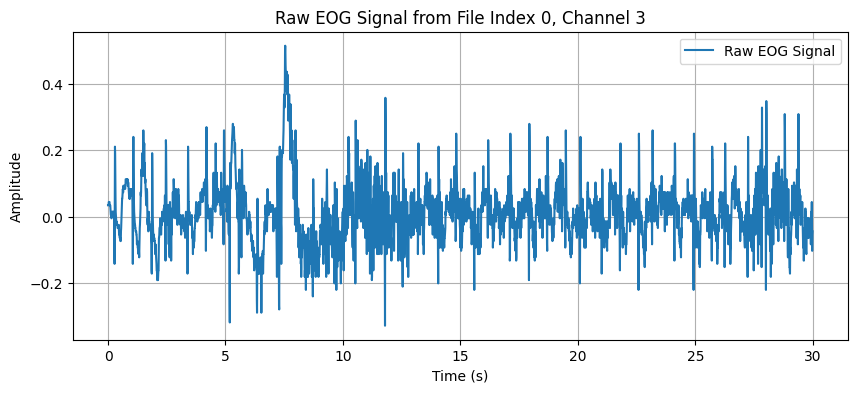

In [5]:
xml_data = load_xml_mat(xml_mat_path)

# For EDF data, use our edf_data_import module; here, we simulate EDF extraction via our dummy function in eog_channel_align_xml.
edf_mat_path = "../data/EDF_RawData.mat"

# Import our EOG alignment module
from utils.eog.eog_channel_align_xml import process_eog_channel_with_xml

# Choose which EDF file index to process (e.g., 0) and which EOG channel to use (adjust based on your header inspection)
file_index = 0
# Suppose the EOG channel you want is at index 3 (this should be determined by inspecting hdr['label'] in your EDF data)
eog_channel_idx = 3

# Process the chosen EDF file: extract EOG epochs, compute features, and attach sleep stage labels
df_eog_features = process_eog_channel_with_xml(edf_mat_path, xml_data, file_index, eog_channel_idx, epoch_length_sec=30)
print("EOG Features for each 30-second epoch:")
display(df_eog_features)

# --- Visualization ---
# Plot an example 30-second segment of raw and (optionally) preprocessed EOG signal.
# Assume we re-load a raw EOG signal from the EDF data using extract_eeg_signal (for demonstration)
from data.edf_data_import import extract_eeg_signal
raw_eog_signal = extract_eeg_signal(edf_mat_path, file_index, channel=eog_channel_idx)
fs_eog = 125  # Assuming 125 Hz sampling
# Select a 30-second segment from the beginning
segment_length = 30 * fs_eog
t = np.arange(segment_length) / fs_eog

plt.figure(figsize=(10, 4))
plt.plot(t, raw_eog_signal[:segment_length], label='Raw EOG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Raw EOG Signal from File Index {file_index}, Channel {eog_channel_idx}')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# 1. Standardize the features (using z-score normalization) and perform cross-validation.
# 2. Train classifiers (e.g., Random Forest, SVM) to predict sleep stages.
# 3. Plot confusion matrices, compare classification accuracy, and tune your wavelet or artifact rejection settings.

## 3. EMG (Electromyogram) – Muscle activity

In [ ]:
# Load the MAT file
# Calculate  Mean, variance, RMS, peak-to-peak, zero crossings

In [ ]:
#Frequency-domain features (FFT, Welch PSD):
#Relative power in delta, theta, alpha, beta, gamma bands
#	•	Bandpower ratios (e.g., delta/alpha, theta/beta)
#	•	Spectral entropy, median frequency

## 4. ECG (Electrocardiogram) – Heart activity

In [ ]:
# Load the MAT file
# Calculate  Mean, variance, RMS, peak-to-peak, zero crossings

In [ ]:
#Frequency-domain features (FFT, Welch PSD):
#Relative power in delta, theta, alpha, beta, gamma bands
#	•	Bandpower ratios (e.g., delta/alpha, theta/beta)
#	•	Spectral entropy, median frequency

## 5. Body Position

In [5]:
# Load the MAT file
# Calculate  Mean, variance, RMS, peak-to-peak, zero crossings

In [ ]:
#Frequency-domain features (FFT, Welch PSD):
#Relative power in delta, theta, alpha, beta, gamma bands
#	•	Bandpower ratios (e.g., delta/alpha, theta/beta)
#	•	Spectral entropy, median frequency

## 6. SpO2 (Oxygen Saturation)

In [ ]:
# Load the MAT file
# Calculate  Mean, variance, RMS, peak-to-peak, zero crossings

In [ ]:
#Frequency-domain features (FFT, Welch PSD):
#Relative power in delta, theta, alpha, beta, gamma bands
#	•	Bandpower ratios (e.g., delta/alpha, theta/beta)
#	•	Spectral entropy, median frequency

## 7. Thoracic and Abdominal Respiration

In [ ]:
# Load the MAT file
# Calculate  Mean, variance, RMS, peak-to-peak, zero crossings

In [ ]:
#Frequency-domain features (FFT, Welch PSD):
#Relative power in delta, theta, alpha, beta, gamma bands
#	•	Bandpower ratios (e.g., delta/alpha, theta/beta)
#	•	Spectral entropy, median frequency

## 8. Cross-signal features:

---------------------------------------------

## XML Data 

In [5]:
xml_data = load_xml_mat(xml_mat_path)
describe_xml_data_structure(xml_data)

first_xml_data = get_xml_file_data(xml_data, 4)
print("Data for R4.xml:")
print("  File Name:", first_xml_data["fileName"])
print("  Epoch Length:", first_xml_data["epochLength"])
print("  Annotation Flag:", first_xml_data["annotation"])
print("  Number of Events:", len(first_xml_data["events"]))
print("  Number of Sleep Stage Entries:", len(first_xml_data["stages"]))

# Inspect the first event
if first_xml_data["events"]:
    first_event = first_xml_data["events"][0]
    print("  First event details:")
    for k, v in first_event.items():
        print(f"    {k}: {v}")

# Example: Filter and inspect HemoglobinOxygenDesaturationFinding events
desat_events = [event for event in first_xml_data["events"]
                if "HemoglobinOxygenDesaturationFinding" in event["EventConcept"]]
print("Number of desaturation events in R4.xml:", len(desat_events))
if desat_events:
    print("  First desaturation event:")
    for k, v in desat_events[0].items():
        print(f"    {k}: {v}")

Keys in MAT file:
 - allData

Structure of 'allData':
  Attribute MATLAB_class: b'struct'
  Attribute MATLAB_fields: [array([...], dtype='|S1'), array([...], dtype='|S1'), array([...], dtype='|S1')]

Fields in allData:
  Field: fileName
  Field: events
  Field: stages
  Field: epochLength
  Field: annotation

Decoded file names from 'allData':
  1: R1.xml
  2: R10.xml
  3: R2.xml
  4: R3.xml
  5: R4.xml
  6: R5.xml
  7: R6.xml
  8: R7.xml
  9: R8.xml
  10: R9.xml

Validating structure for 10 elements:
Element 1:
  fileName: R1.xml (type: str)
  events: 371 events (type: list)
  stages: length 32490 (type: list)
  epochLength: 30.0 (type: float)
  annotation: 1 (type: int)

Element 2:
  fileName: R10.xml (type: str)
  events: 215 events (type: list)
  stages: length 32490 (type: list)
  epochLength: 30.0 (type: float)
  annotation: 1 (type: int)

Element 3:
  fileName: R2.xml (type: str)
  events: 450 events (type: list)
  stages: length 32340 (type: list)
  epochLength: 30.0 (type: flo